# Visualisierung als Zeitleiste

Die Metadaten der dem Topic Model zugrundeliegenden Dokumente enthalten auch Zeitangaben. Diese Dimension ist in den bisherigen Analysen nicht berücksichtigt worden. Das zeitliche Auftreten und Verschwinden von Themen kann jedoch eine lohnende Analyseebene sein. Als Visualisierung bietet sich hierbei eine Zeitleiste an.

In [1]:
from cPickle import load
import pandas as pd

with open('../07_Topic_Modeling/topicmodel20.pickle', 'rb') as picklefile:
    ldamodel = load(picklefile)

data = pd.read_csv("../Daten/reden.csv", parse_dates=['date'], encoding='utf-8')

Die Grundidee ist hierbei relativ simpel: Jedem Dokument wird sein Top-Topic zugewiesen. (Da Topic 0 sowohl sehr dominant als auch inhaltlich aussageschwach ist, wird es dabei ausgeschlossen. Auch Topic 13 wird entfernt. Die Liste muss von Fall zu Fall angepasst werden.) Diese Information wird als neue Spalte der Dokumententabelle hinzugefügt.

In [2]:
skiptopics = [0, 13]
toptopics = []
doc_topic = ldamodel.doc_topic_
for doc in doc_topic:
    topics = doc.argsort()
    for st in skiptopics:
        topics = topics[topics != st]
    toptopics.append(topics[-1])
data['toptopic'] = toptopics
data[:10]

,place,title,date,text,abstract,link,toptopic
0,Weimar,Laudatio auf Rüdiger Safranski,2014-07-06,- Es gilt das gesprochene Wort. -\r\nEs gehört...,Der Schriftsteller und Literaturwissenschaftle...,http://www.bundesregierung.de/Content/DE/Rede/...,7
1,Peking,Rede von Bundeskanzlerin Merkel anlässlich der...,2014-07-08,"Sehr geehrter Herr Minister Miao Wei,\r\nmeine...",in Peking\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,10
2,Peking,Rede von Bundeskanzlerin Merkel anlässlich des...,2014-07-08,"Sehr geehrter Herr Präsident,\r\nsehr geehrte,...",NaN,http://www.bundesregierung.de/Content/DE/Rede/...,5
3,Alliiertenmuseum Berlin,Kulturstaatsministerin Monika Grütters zur Erö...,2014-07-08,"- Es gilt das gesprochene Wort. -\r\nAnrede,\r...","""Wer verstehen will, warum uns mit den USA wei...",http://www.bundesregierung.de/Content/DE/Rede/...,7
4,NaN,Rede von Bundeskanzlerin Merkel anlässlich der...,2014-07-11,"Sehr geehrter Herr Meyer,\r\nsehr geehrte Frau...",in Rostock-Warnemünde\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,17
5,NaN,Rede von Bundeskanzlerin Merkel anlässlich des...,2014-07-14,"Sehr geehrter Herr Präsident, lieber Herr Huma...",in Berlin\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,5
6,Bonn,Rede von Bundeskanzlerin Merkel zum Treffen mi...,2014-08-19,"Lieber Herr Bundesminister de Maizière, lieber...",NaN,http://www.bundesregierung.de/Content/DE/Rede/...,6
7,Lindau,Rede von Bundeskanzlerin Merkel zum 5. Treffen...,2014-08-20,"Sehr geehrte Gräfin Bernadotte,\r\nsehr geehrt...",in Lindau\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,3
8,Berlin,Rede von Bundeskanzlerin Merkel zum Tag der He...,2014-08-30,"Sehr geehrte Frau Präsidentin, liebe Erika Ste...",in Berlin\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,1
9,NaN,Rede zur Eröffnung des Gedenk- und Information...,2014-09-02,"- Es gilt das gesprochene Wort. -\r\nAnrede,\r...","""Die Verbrechen der Nationalsozialisten aufzua...",http://www.bundesregierung.de/Content/DE/Rede/...,1


Für die Zeitleiste sind die Datumsangaben der Dokumente zu detailliert. Um eine größere Tendenz feststellen zu können, sollen jeweils Jahre zusammengefasst werden. Daher wird eine neue Spalte hinzugefügt, die nur das Jahr enthält.

In [3]:
data['year'] = data['date'].apply(lambda date: date.year)
data[:10]

,place,title,date,text,abstract,link,toptopic,year
0,Weimar,Laudatio auf Rüdiger Safranski,2014-07-06,- Es gilt das gesprochene Wort. -\r\nEs gehört...,Der Schriftsteller und Literaturwissenschaftle...,http://www.bundesregierung.de/Content/DE/Rede/...,7,2014
1,Peking,Rede von Bundeskanzlerin Merkel anlässlich der...,2014-07-08,"Sehr geehrter Herr Minister Miao Wei,\r\nmeine...",in Peking\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,10,2014
2,Peking,Rede von Bundeskanzlerin Merkel anlässlich des...,2014-07-08,"Sehr geehrter Herr Präsident,\r\nsehr geehrte,...",NaN,http://www.bundesregierung.de/Content/DE/Rede/...,5,2014
3,Alliiertenmuseum Berlin,Kulturstaatsministerin Monika Grütters zur Erö...,2014-07-08,"- Es gilt das gesprochene Wort. -\r\nAnrede,\r...","""Wer verstehen will, warum uns mit den USA wei...",http://www.bundesregierung.de/Content/DE/Rede/...,7,2014
4,NaN,Rede von Bundeskanzlerin Merkel anlässlich der...,2014-07-11,"Sehr geehrter Herr Meyer,\r\nsehr geehrte Frau...",in Rostock-Warnemünde\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,17,2014
5,NaN,Rede von Bundeskanzlerin Merkel anlässlich des...,2014-07-14,"Sehr geehrter Herr Präsident, lieber Herr Huma...",in Berlin\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,5,2014
6,Bonn,Rede von Bundeskanzlerin Merkel zum Treffen mi...,2014-08-19,"Lieber Herr Bundesminister de Maizière, lieber...",NaN,http://www.bundesregierung.de/Content/DE/Rede/...,6,2014
7,Lindau,Rede von Bundeskanzlerin Merkel zum 5. Treffen...,2014-08-20,"Sehr geehrte Gräfin Bernadotte,\r\nsehr geehrt...",in Lindau\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,3,2014
8,Berlin,Rede von Bundeskanzlerin Merkel zum Tag der He...,2014-08-30,"Sehr geehrte Frau Präsidentin, liebe Erika Ste...",in Berlin\r\n,http://www.bundesregierung.de/Content/DE/Rede/...,1,2014
9,NaN,Rede zur Eröffnung des Gedenk- und Information...,2014-09-02,"- Es gilt das gesprochene Wort. -\r\nAnrede,\r...","""Die Verbrechen der Nationalsozialisten aufzua...",http://www.bundesregierung.de/Content/DE/Rede/...,1,2014


Für jedes Jahr soll nun gezählt werden, welches Topic wie häufig vorkommt. Für die Visualisierung wird also eine Tabelle benötigt, die Topics und Jahre als Achsen enthält, mit der Häufigkeit von Topic pro Jahr in den Zellen.

`pandas.DataFrame`s verfügen über eine komfortable Funktion zum Gruppieren von Daten. Die Gesamttabelle kann also nach Jahr und Topic gruppiert werden. Um die Anzahl der Topics pro Jahr zu ermitteln, wird dann gezählt, wie viele Einträge jede dieser Gruppen enthält. Da die Gruppen nicht direkt gezählt werden können, wird hier die Länge einer beliebigen anderen Spalte, hier die Titel, verwendet. Wichtig ist nur, dass die gewählte Spalte keine fehlenden Einträge enthält.

In [4]:
topic_by_year = data.groupby(['year', 'toptopic'])['title'].count()
topic_by_year[:10]

year  toptopic
2009  2           3
      3           4
      4           2
      5           1
      7           7
      8           2
      9           2
      10          1
      14          1
      18          1
Name: title, dtype: int64

Das Ergebnis ist eine verschachtelte Tabelle, die für jedes Jahr jeweils die Anzahl Top-Topics aufführt. Um die gewünschte Tabelle von Jahr und Topic zu erhalten, kann diese Tabelle »entschachtelt« werden.

In [5]:
topic_by_year = topic_by_year.unstack()
topic_by_year[:10]

toptopic,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19
year,,,,,,,,,,,,,,,,,,
2009,NaN,3,4,2,1,NaN,7,2,2,1,NaN,NaN,1,NaN,NaN,NaN,1,NaN
2010,5,23,17,4,6,9,13,3,6,17,3,3,9,NaN,NaN,4,4,4
2011,8,25,17,10,7,10,16,5,12,16,3,2,4,2,1,5,2,3
2012,5,25,13,11,5,17,11,4,2,11,4,4,2,NaN,NaN,3,NaN,4
2013,10,14,11,11,9,10,7,4,1,15,15,NaN,3,3,NaN,1,NaN,2
2014,4,15,5,2,3,4,12,7,1,9,5,3,NaN,NaN,NaN,3,1,1


*Hinweis:* Diese Datentransformationen sind auf den ersten Blick nicht leicht zu verstehen. Pandas ist hier (ähnlich wie R) sehr mächtig, aber auch gelegentlich obskur. Da solche Datentransformationen aber in vielen Fällen hilfreich sind, lohnt sich unter Umständen die Beschäftigung mit den verfügbaren Möglichkeiten. Dies erfordert neben der Lektüre der [Pandas-Dokumentation](http://pandas.pydata.org/pandas-docs/version/0.15.1/10min.html) aber vor allem Geduld und Experimentierfreude.

Die absoluten Zahlen können schon verwendet werden. Wenn der Fokus aber eher auf den relativen Veränderungen liegen soll, können die Zahlen noch normalisiert werden. Für jedes Jahr wird dann der relative Anteil eines Topics berechnet, nicht die absolute Zahl der Dokumente mit diesem Topic.

Die Normalisierungsfunktion berechnet für eine Wertreihe die Anteile. Über die Methode `DataFrame.apply()` kann diese Funktion nun auf alle Zeilen (`axis=1`, ansonsten erfolgt die Berechnung spaltenweise) angewandt werden.

In [6]:
normalize = lambda x: x / x.sum()

topic_by_year.apply(normalize, axis=1)

toptopic,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19
year,,,,,,,,,,,,,,,,,,
2009,NaN,0.125000,0.166667,0.083333,0.041667,NaN,0.291667,0.083333,0.083333,0.041667,NaN,NaN,0.041667,NaN,NaN,NaN,0.041667,NaN
2010,0.038462,0.176923,0.130769,0.030769,0.046154,0.069231,0.100000,0.023077,0.046154,0.130769,0.023077,0.023077,0.069231,NaN,NaN,0.030769,0.030769,0.030769
2011,0.054054,0.168919,0.114865,0.067568,0.047297,0.067568,0.108108,0.033784,0.081081,0.108108,0.020270,0.013514,0.027027,0.013514,0.006757,0.033784,0.013514,0.020270
2012,0.041322,0.206612,0.107438,0.090909,0.041322,0.140496,0.090909,0.033058,0.016529,0.090909,0.033058,0.033058,0.016529,NaN,NaN,0.024793,NaN,0.033058
2013,0.086207,0.120690,0.094828,0.094828,0.077586,0.086207,0.060345,0.034483,0.008621,0.129310,0.129310,NaN,0.025862,0.025862,NaN,0.008621,NaN,0.017241
2014,0.053333,0.200000,0.066667,0.026667,0.040000,0.053333,0.160000,0.093333,0.013333,0.120000,0.066667,0.040000,NaN,NaN,NaN,0.040000,0.013333,0.013333


Aus kosmetischen Gründen wird die Jahresliste von Zahlen (int) in Zeichen (str) umgewandelt. Dies verhindert, dass pandas die Darstellung der Zahlen eigenmächtig verändert.

In [7]:
topic_by_year.index = topic_by_year.index.astype(str)

Die normalisierte Tabelle kann mit den Plotting-Möglichkeiten von Pandas gezeichnet werden. In diesem Fall bietet sich ein sogenanntes Area-Plot an, aber auch ein Liniendiagramm wäre möglich.

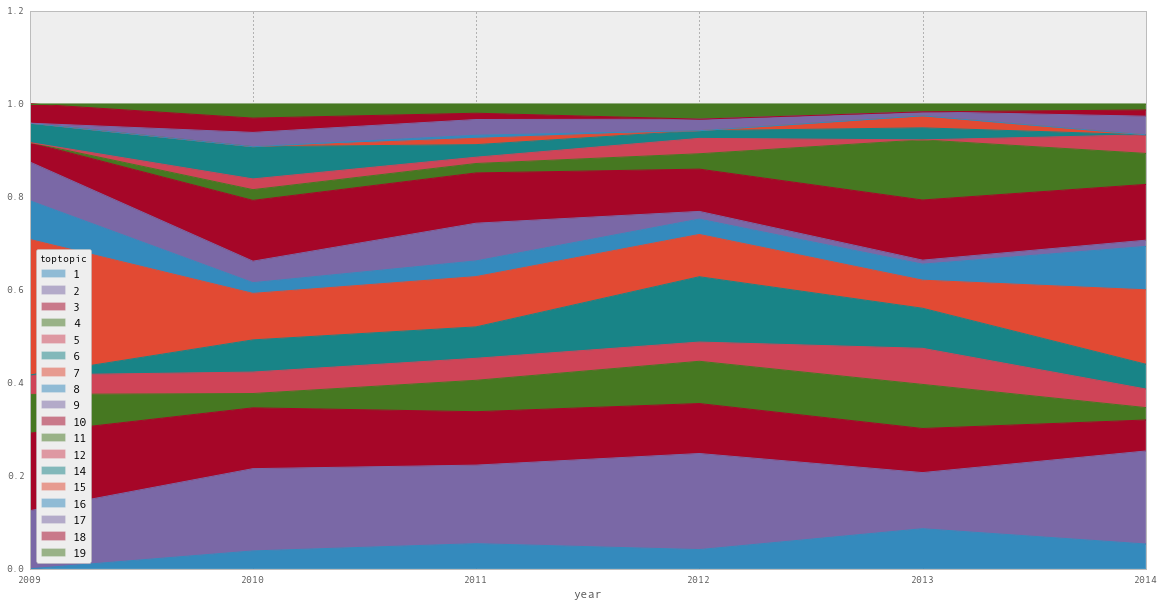

In [9]:
%matplotlib inline
pd.options.display.mpl_style = 'default'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 10

topic_by_year.apply(normalize, axis=1).plot(kind='area')